# importing libraries and defining data path

In [15]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision.transforms as T
import cv2 as cv
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR

real_data = "/kaggle/input/socofing/SOCOFing/Real"
altered_data = "/kaggle/input/socofing/SOCOFing/Altered"

# Exploratory data analysis (EDA)

- the real data contain 6000 fingerprint for 600 subject as every subject has 10 fingerprints that represents the five fingers for every hand .
- the altered data is the same data with some augmentation .
- there are three differnt versions of the altered data : easy-medium-hard .
- the augmentation of the data is : obliteration, central rotation, and z-cut .
- the names for every photo is in format \[(subject_index)_(gender)_(finger_name).BMP\]
<p>
- the finger names with their corresponding labels are:<br/>
1) index_finger    ----> 0<br/>
2) little_finger   ----> 1<br/>
3) middle_finger   ----> 2<br/>
4) ring_finger     ----> 3<br/>
5) thumb_finger    ----> 4<br/>
<p/>

- we will use the real and altered data to construct the CNN model .
- the altered data will be used to determine the distance threshold .

In [2]:
data = []
labels = []

# load the real data and their labels
photos_names = os.listdir(real_data)
for name in photos_names:
    data.append(cv.imread(os.path.join(real_data ,name) ,cv.IMREAD_GRAYSCALE))
    temp = name.split("_")[4]
    if temp == "index" : labels.append(0)
    elif temp == "little" : labels.append(1)
    elif temp == "middle" : labels.append(2)
    elif temp == "ring" : labels.append(3)
    else : labels.append(4)

# load the altered data and their labels
dirs = ["Altered-Easy" ,"Altered-Hard" ,"Altered-Medium"]
for folder in dirs:
    photos_names = os.listdir(os.path.join(altered_data ,folder))
    for name in photos_names:
        data.append(cv.imread(os.path.join(altered_data ,folder ,name) ,cv.IMREAD_GRAYSCALE))
        temp = name.split("_")[4]
        if temp == "index" : labels.append(0)
        elif temp == "little" : labels.append(1)
        elif temp == "middle" : labels.append(2)
        elif temp == "ring" : labels.append(3)
        else : labels.append(4)

- creating histograms to determine the best image width and height to resize all images to that size as we don't want to remove any necessary information

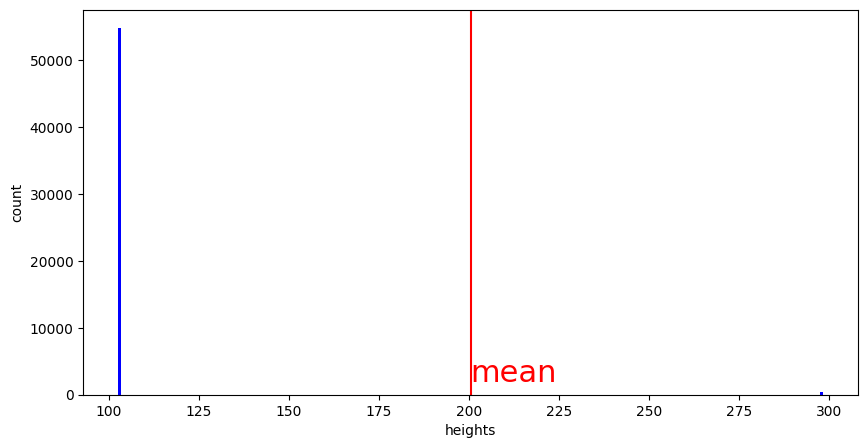

In [14]:
# creating height histogram
hist = {}
for image in data:
    height = image.shape[0]
    hist[height] = hist.get(height ,0) + 1
    
x = list(hist.keys())
y = [hist[i] for i in x]
mean = np.array(x).mean()
plt.figure(figsize = (10, 5))
plt.bar(np.array(x),np.array(y),color="b")
plt.axvline(x = mean, color = 'r', label = 'mean')
plt.text(mean, 2000, 'mean', fontsize = 22 ,color = 'r') 
plt.xlabel("heights")
plt.ylabel("count")
plt.show()

- so apparently that the best height is 103 as most of the data has that height but the rest can be considered as outliers.

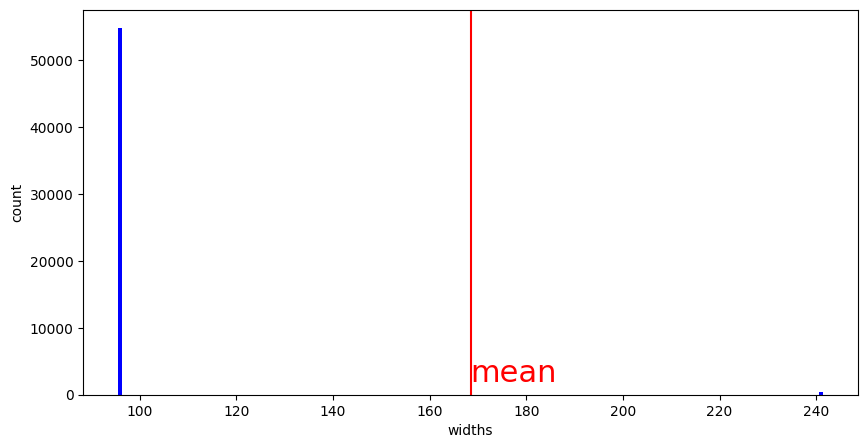

In [15]:
# creating width histogram
hist = {}
for image in data:
    width = image.shape[1]
    hist[width] = hist.get(width ,0) + 1
    
x = list(hist.keys())
y = [hist[i] for i in x]
mean = np.array(x).mean()
plt.figure(figsize = (10, 5))
plt.bar(np.array(x),np.array(y),color="b")
plt.axvline(x = mean, color = 'r', label = 'mean')
plt.text(mean, 2000, 'mean', fontsize = 22 ,color = 'r') 
plt.xlabel("widths")
plt.ylabel("count")
plt.show()

- so apparently that the best width is 96 as most of the data has that height but the rest can be considered as outliers.

# preparing the real data and splitting it to train ,validation and test data

In [3]:
# resizeing all the data to 103X96
for i,image in enumerate(data):
    data[i] = cv.resize(image ,(96,103))

In [4]:
# normalizing the data
for i,image in enumerate(data):
    mean = image.mean()
    std = image.std()
    image = (image.astype(np.float32) - mean)/std
    data[i] = image

In [5]:
# adding the gray channel 
for i,image in enumerate(data):
    data[i] = image[np.newaxis,...]

In [6]:
# splitting the data
x_train_val ,x_test ,y_train_val ,y_test = train_test_split(data ,labels ,test_size=0.2 ,random_state=2509)
x_train ,x_val ,y_train ,y_val = train_test_split(x_train_val ,y_train_val ,test_size=0.125 ,random_state=2509)

# defining hyperparameters ,loss function ,learning rate scheduler and the model architecture

In [7]:
# the hyperparameters
batch_size = 128
lr = 0.0007
weight_decay = 0.001
output_num = 5
input_shape = (103,96)
dropout_p = 0.4
epochs = 400
gamma_scheduler = 0.97
scheduler_steps = 30

# the loss function
criteria = nn.CrossEntropyLoss()

# model class
class Archit(nn.Module):
    
    def __init__(self ,dropout_p):
        super(Archit,self).__init__()
        #-----------------------block1---------------------------------
        self.conv1 = nn.Conv2d(1,16,(5,5),(1,1))  # 1X103X96 --> 16X99X92
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d((3,2),(2,2))   # 16X99X92  --> 16X49X46
        #-----------------------block2---------------------------------
        self.norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,(3,3),(1,1)) # 16X49X46  --> 32X47X44
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d((3,2),(2,2))   # 32X47X44  --> 32X23X22
        self.dropout1 = nn.Dropout2d(dropout_p*0.2)
        #-----------------------block3----------------------------------
        self.norm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,64,(3,3),(1,1)) # 32X23X22  --> 64X21X20
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d((3,2),(2,2))   # 64X21X20  --> 64X10X10
        self.dropout2 = nn.Dropout2d(dropout_p*0.4)
        
        #---------------------channel attention-------------------------
        self.avg_pool = nn.AvgPool2d((10,10),1)
        self.flatten1 = nn.Flatten()
        self.norm3 = nn.BatchNorm1d(64)
        self.linear1 = nn.Linear(64,128)
        self.activ = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_p*0.6)
        self.norm4 = nn.BatchNorm1d(128)
        self.linear2 = nn.Linear(128,64)
        self.sigmoid = nn.Sigmoid()
        self.dropout4 = nn.Dropout(dropout_p*0.8)
        #------------------------classifier------------------------------
        
        self.flatten2 = nn.Flatten()
        self.norm5 = nn.BatchNorm1d(64*10*10)
        self.linear3 = nn.Linear(64*10*10 ,5)
        self.dropout5 = nn.Dropout(dropout_p)
        
    def forward(self ,x):
        
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.norm1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout1(x)
        
        x = self.norm2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.dropout2(x)
        
        avg = self.avg_pool(x)
        avg = self.flatten1(avg)
        avg = self.norm3(avg)
        avg = self.linear1(avg)
        avg = self.activ(avg)
        avg = self.dropout3(avg)
        avg = self.norm4(avg)
        avg = self.linear2(avg)
        avg = self.sigmoid(avg)
        avg = torch.stack([avg for _ in range(100)] ,dim=-1).view(-1,64,10,10)
        atten = x * avg
        x = self.dropout4(atten)
        
        x = self.flatten2(x)
        x = self.norm5(x)
        x = self.linear3(x)
        x = self.dropout5(x)
        return x

# initialization of the model
model = Archit(dropout_p)

# the optimizer
optimizer = torch.optim.Adam(model.parameters() ,lr=lr ,weight_decay=weight_decay)

# learning rate scheduler
scheduler = StepLR(optimizer ,step_size=scheduler_steps ,gamma=gamma_scheduler)

# defining the training loop

- we will use early stopping and we will monitor the validation loss metric as every 15 epochs if the accuracy is dropped than 10% then we stop and take the best model from the previous runs .
- we will change the learning rate every 30 epochs as by :
$$lr_{new}=0.97*lr_{old}$$

- we will implement early stopping with patience on the loss which means that if the absolute differnce betwwen the loss and the best loss is not greater than a threshold in pre-determined conscutive times and the loss is not improving then we stop and capture the best loss but otherwise ,we continue 

In [8]:
# batching the data as list of numpy array 
nu_train_batches = int(np.ceil(len(x_train)/batch_size))
nu_val_batches = int(np.ceil(len(x_val)/batch_size))
nu_test_batches = int(np.ceil(len(x_test)/batch_size))

train = []
tr_label = []
val = []
val_label = []
test = []
test_label = []

pointer = 0
while nu_train_batches > 0:
    train.append(np.stack(x_train[pointer:pointer+batch_size] ,axis=0))
    tr_label.append(np.stack(y_train[pointer:pointer+batch_size] ,axis=0))
    pointer += batch_size
    nu_train_batches -= 1
    
pointer = 0
while nu_val_batches > 0:
    val.append(np.stack(x_val[pointer:pointer+batch_size] ,axis=0))
    val_label.append(np.stack(y_val[pointer:pointer+batch_size] ,axis=0))
    pointer += batch_size
    nu_val_batches -= 1

pointer = 0
while nu_test_batches > 0:
    test.append(np.stack(x_test[pointer:pointer+batch_size] ,axis=0))
    test_label.append(np.stack(y_test[pointer:pointer+batch_size] ,axis=0))
    pointer += batch_size
    nu_test_batches -= 1

In [9]:
patience = 15
best_loss = np.inf
accuracy_train_all = []
loss_train_all = []
accuracy_val_all = []
loss_val_all = []
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for e in range(epochs):
    print(f"epoch : {e+1}/{epochs}")
    
    accuracy_train = []
    loss_train = []
    accuracy_val = []
    loss_val = []
    
    model.train()
    for data,labels in zip(train ,tr_label):
        data = torch.tensor(data).to(device)
        labels = torch.tensor(labels).to(device)
        output = model(data)
        optimizer.zero_grad()
        loss = criteria(output ,labels)
        loss.backward()
        optimizer.step()
        loss_train.append(loss.item())
        accuracy = torch.sum(torch.argmax(torch.softmax(output ,dim=-1) ,dim=-1) == labels)/len(data)
        accuracy_train.append(accuracy.item())
    
    loss = sum(loss_train)/len(loss_train)
    accuracy = sum(accuracy_train)/len(accuracy_train)
    loss_train_all.append(loss)
    accuracy_train_all.append(accuracy)
    print(f"train loss : {loss:.3f} ,train accuracy : {accuracy*100:.3f}% ," ,end ="")
    scheduler.step()
    
    model.eval()
    with torch.no_grad():
        
        for data,labels in zip(val ,val_label):
            data = torch.tensor(data).to(device)
            labels = torch.tensor(labels).to(device)
            output = model(data)
            loss = criteria(output ,labels)
            loss_val.append(loss.item())
            accuracy = torch.sum(torch.argmax(torch.softmax(output ,dim=-1) ,dim=-1) == labels)/len(data)
            accuracy_val.append(accuracy.item())
    
    loss = sum(loss_val)/len(loss_val)
    accuracy = sum(accuracy_val)/len(accuracy_val)
    loss_val_all.append(loss)
    accuracy_val_all.append(accuracy)
    print(f"validation loss : {loss:.3f} ,validation accuracy : {accuracy*100:.3f}%\n")
    
    if 0.05 < np.abs(best_loss-loss) and loss<best_loss:
        torch.save(model.state_dict(), "./model.pt")
        best_loss = loss
        patience = 15
    else:
        patience -= 1
    
    if patience == 0:
        print("\n\n","done".center(100,"-") ,sep="")
        break
        

epoch : 1/400
train loss : 1.368 ,train accuracy : 41.752% ,validation loss : 0.950 ,validation accuracy : 64.002%

epoch : 2/400
train loss : 1.218 ,train accuracy : 47.053% ,validation loss : 0.864 ,validation accuracy : 68.522%

epoch : 3/400
train loss : 1.135 ,train accuracy : 50.284% ,validation loss : 0.816 ,validation accuracy : 71.117%

epoch : 4/400
train loss : 1.082 ,train accuracy : 52.364% ,validation loss : 0.793 ,validation accuracy : 72.109%

epoch : 5/400
train loss : 1.034 ,train accuracy : 54.493% ,validation loss : 0.733 ,validation accuracy : 76.063%

epoch : 6/400
train loss : 0.996 ,train accuracy : 55.857% ,validation loss : 0.702 ,validation accuracy : 78.478%

epoch : 7/400
train loss : 0.957 ,train accuracy : 57.510% ,validation loss : 0.679 ,validation accuracy : 79.543%

epoch : 8/400
train loss : 0.936 ,train accuracy : 58.668% ,validation loss : 0.665 ,validation accuracy : 82.305%

epoch : 9/400
train loss : 0.911 ,train accuracy : 59.726% ,validation l

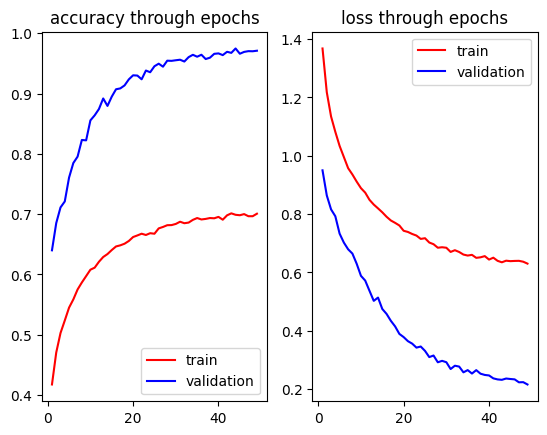

In [10]:
# plotting the loss and the accuracy 
figure, axis = plt.subplots(1, 2) 
x = np.arange(1,e+2)

y = np.array(accuracy_train_all)
axis[0].plot(x,y ,color="red" ,label="train")
y = np.array(accuracy_val_all)
axis[0].plot(x,y ,color="blue" ,label="validation")
axis[0].set_title("accuracy through epochs")
axis[0].legend() 

y = np.array(loss_train_all)
axis[1].plot(x,y ,color="red" ,label="train")
y = np.array(loss_val_all)
axis[1].plot(x,y ,color="blue" ,label="validation")
axis[1].set_title("loss through epochs")
axis[1].legend() 
plt.show()

# testing the model

In [11]:
# testing loop
train_loss = []
train_accuracy = []
model.eval()
model.to(device)
with torch.no_grad():     
    for data,labels in zip(test ,test_label):
        data = torch.tensor(data).to(device)
        labels = torch.tensor(labels).to(device)
        output = model(data)
        loss = criteria(output ,labels)
        train_loss.append(loss.item())
        accuracy = torch.sum(torch.argmax(torch.softmax(output ,dim=-1) ,dim=-1) == labels)/len(data)
        train_accuracy.append(accuracy.item())
    
loss = sum(train_loss)/len(train_loss)
accuracy = sum(train_accuracy)/len(train_accuracy)
print(f"test loss : {loss:.3f} ,test accuracy : {accuracy*100:.3f}%\n")

test loss : 0.215 ,test accuracy : 96.897%



# determining the distance threshold and wrapping the model in an inference model

- we will determine the threshold by calculating the euclidean distance of the feature vector produced by the convolution part (head of the model) to every photo and it is augmentation (easy ,medium or hard) separately so we will have three thresholds .
- and for every threshold we will take the minimun of the euclidean distances and the final will be the mean of the three.
- in wrapping the model we have two mods which either adding new fingerprint or comparing a fingerprint to existing fingerprints and find if it exsist in the system .

In [12]:
# loading the saved model but with adjusting the return value to be the feature vector as well
# and redefining the architecture for those changes
class Archit(nn.Module):
    
    def __init__(self ,dropout_p):
        super(Archit,self).__init__()
        #-----------------------block1---------------------------------
        self.conv1 = nn.Conv2d(1,16,(5,5),(1,1))  # 1X103X96 --> 16X99X92
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d((3,2),(2,2))   # 16X99X92  --> 16X49X46
        #-----------------------block2---------------------------------
        self.norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,(3,3),(1,1)) # 16X49X46  --> 32X47X44
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d((3,2),(2,2))   # 32X47X44  --> 32X23X22
        self.dropout1 = nn.Dropout2d(dropout_p*0.2)
        #-----------------------block3----------------------------------
        self.norm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,64,(3,3),(1,1)) # 32X23X22  --> 64X21X20
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d((3,2),(2,2))   # 64X21X20  --> 64X10X10
        self.dropout2 = nn.Dropout2d(dropout_p*0.4)
        
        #---------------------channel attention-------------------------
        self.avg_pool = nn.AvgPool2d((10,10),1)
        self.flatten1 = nn.Flatten()
        self.norm3 = nn.BatchNorm1d(64)
        self.linear1 = nn.Linear(64,128)
        self.activ = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_p*0.6)
        self.norm4 = nn.BatchNorm1d(128)
        self.linear2 = nn.Linear(128,64)
        self.sigmoid = nn.Sigmoid()
        self.dropout4 = nn.Dropout(dropout_p*0.8)
        #------------------------classifier------------------------------
        
        self.flatten2 = nn.Flatten()
        self.norm5 = nn.BatchNorm1d(64*10*10)
        self.linear3 = nn.Linear(64*10*10 ,5)
        self.dropout5 = nn.Dropout(dropout_p)
        
    def forward(self ,x):
        
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.norm1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout1(x)
        
        x = self.norm2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.dropout2(x)
        
        avg = self.avg_pool(x)
        avg = self.flatten1(avg)
        avg = self.norm3(avg)
        avg = self.linear1(avg)
        avg = self.activ(avg)
        avg = self.dropout3(avg)
        avg = self.norm4(avg)
        avg = self.linear2(avg)
        avg = self.sigmoid(avg)
        avg = torch.stack([avg for _ in range(100)] ,dim=-1).view(-1,64,10,10)
        atten = x * avg
        x = self.dropout4(atten)
        
        y = self.flatten2(x)
        
        x = self.norm5(y)
        x = self.linear3(x)
        x = self.dropout5(x)
        return x,y
    
saved_model = "/kaggle/working/model.pt"
model = Archit(dropout_p)
model.load_state_dict(torch.load(saved_model))
model.to(device)
model.eval()

Archit(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=(3, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=(3, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.08000000000000002, inplace=False)
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=(3, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.16000000000000003, inplace=False)
  (avg_pool): AvgPool2d(kernel_size=(10, 10), stride=1, padding=0)
  (flatten1): Flatten(start_dim=1, end_dim=-1)
  (norm3): BatchNorm1d(64, eps=1e-05, momentum=0

In [60]:
# extracting the threshold
easy_thresholds = []
medium_thresholds = []
hard_thresholds = []

# load the real data and their labels
# key:value ---> participant_id:{0:data,...}
photos_names = os.listdir(real_data)
real = {i:{j:None for j in range(5)} for i in range(1,600+1)} 
for name in photos_names:
    label = None
    data = cv.imread(os.path.join(real_data ,name) ,cv.IMREAD_GRAYSCALE)
    data = cv.resize(data ,(96,103))
    mean = data.mean()
    std = data.std()
    data = (data.astype(np.float32) - mean)/std
    data = torch.tensor(data[np.newaxis,np.newaxis,...])
    temp = name.split("_")
    if temp[4] == "index" : label = 0
    elif temp[4] == "little" : label = 1
    elif temp[4] == "middle" : label = 2
    elif temp[4] == "ring" : label = 3
    else : label = 4
    real[int(temp[0])][label] = data 

# load the altered data and their labels
dirs = ["Altered-Easy" ,"Altered-Hard" ,"Altered-Medium"]
for folder in dirs:
    altered = [] # every photo will be in tuple : (participant_id ,photo ,label)
    photos_names = os.listdir(os.path.join(altered_data ,folder))
    for name in photos_names:
        label = None
        data = cv.imread(os.path.join(altered_data ,folder ,name) ,cv.IMREAD_GRAYSCALE)
        data = cv.resize(data ,(96,103))
        mean = data.mean()
        std = data.std()
        data = (data.astype(np.float32) - mean)/std
        data = torch.tensor(data[np.newaxis,np.newaxis,...])
        temp = name.split("_")
        if temp[4] == "index" : label = 0
        elif temp[4] == "little" : label = 1
        elif temp[4] == "middle" : label = 2
        elif temp[4] == "ring" : label = 3
        else : label = 4
        altered.append((int(temp[0]) ,data ,label))
    for item in altered:
        participant_id = item[0]
        data = item[1].to(device)
        label = item[2]
        alter_out = model(data)[1]
        real_out = model(real[participant_id][label].to(device))[1]
        threshold = torch.pow(alter_out - real_out ,2).sum().sqrt().item()
        if folder == "Altered-Easy" : easy_thresholds.append(threshold)
        elif folder == "Altered-Medium" : medium_thresholds.append(threshold)
        else : hard_thresholds.append(threshold)

In [70]:
# finding the treshold
easy = np.mean(easy_thresholds)
medium = np.mean(medium_thresholds)
hard = np.mean(hard_thresholds)
final = np.mean(
    [np.min(easy_thresholds) ,np.min(medium_thresholds) ,np.min(hard_thresholds)])
print(f"final threshold is {final:.5f}")

final threshold is 0.41932


- so the final threshold is 0.41932

In [123]:
# defining the inference arcitecture
class InferenceArchitect:
    
    def __init__(self ,model):
        self.model = model.eval()
        self.threshold = 0.41932
        self.transforms = nn.Sequential(T.Resize([103,96]),
                                        T.ConvertImageDtype(torch.float),
                                        T.Normalize([0.5],[0.5]))
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self ,image ,mode=True ,ids=None):
        # image as numpy 4-D tensor (batch_size ,1 ,height ,width)
        image = torch.tensor(image)
        image = image/255
        image = self.transforms(image)
        if mode: # means extracing feature vector and saving it with the ids given
            if not ids : print("ids is not provided !!")
            if len(ids) != image.shape[0] : print("mismatched number of ids !!")
            with torch.no_grad():
                output,feature = self.model(image.to(device))
                output = self.softmax(output)
                labels = torch.argmax(output ,dim=-1)
            for i in range(image.shape[0]):
                if torch.max(output[i]) >= 0.7:
                    path = os.path.join(os.getcwd() ,str(ids[i]) 
                                        ,str(labels[i].item())+".pt")
                    if os.path.isfile(path):
                        print(f"id alraedy exsist !! : {path}")
                    else:
                        torch.save(feature ,path)
                else:
                    print(f"image #{i+1} can't be classified")
        else:
            with torch.no_grad():
                output,feature = self.model(image)
                output = self.softmax(output)
                labels = torch.argmax(output ,dim=-1)
            ids = os.listdir(os.getcwd())
            for i in range(image.shape[0]):
                possible = []
                if torch.max(output[i]) >= 0.7:
                    for j in ids:
                        if not os.path.isdir(): continue
                        files = os.listdir(os.path.join(os.getcwd() ,j))
                        for file in files:
                            if not file.endswith(".pt"): continue
                            data = torch.load(os.path.join(os.getcwd() ,j ,file)).to(device)
                            try:
                                threshold = torch.pow(data-output[i],2).sum().sqrt().item()
                            except:
                                pass
                            if threshold <= self.threshold: 
                                possible.append((threshold ,j ,file))
                else:
                    print(f"image #{i+1} can't be classified")
                if possible:
                    temp = possible[2][0]
                    if temp == '0' : temp = "index" 
                    elif temp == '1' : temp = "little" 
                    elif temp == '2' : temp = "middle"  
                    elif temp == '3' : temp = "ring" 
                    else : temp = "thumb"
                    print(f"id {possible[1]} and file name {possible[2]}"
                          f"which represent {temp}")
                else:
                    print(f"image #{i+1} can't be don't exsist yet !!")